# Capítulo 2

Esta libreta contiene el código para resolver los principales aspectos del capítulo 2.
Usamos rpy2 para correr código de rethinking.

In [2]:
%load_ext rpy2.ipython

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


Aproximación de rendija (grid).

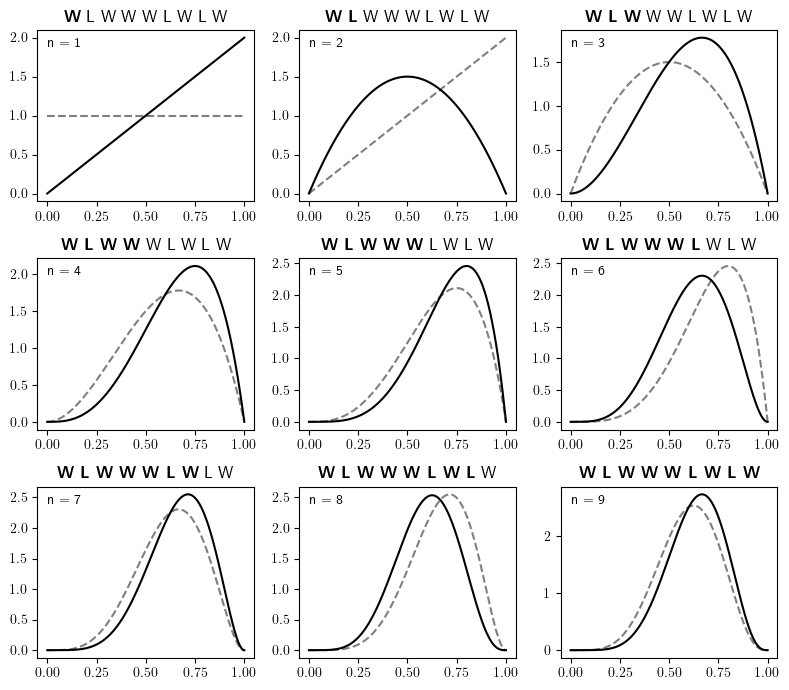

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

x = np.linspace(0, 1, 1000)

def plot_beta(k, n, a0, b0, title=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    beta_prior = stats.beta(a0, b0)
    y_prior = beta_prior.pdf(x)
    ax.plot(x, y_prior, ls='--', c='k', alpha=0.5)
    a1,b1 = a0 + k, b0 + (n-k)
    beta_post = stats.beta(a1, b1)
    y_post = beta_post.pdf(x)
    ax.plot(x, y_post, c='k')
    title = title or f'Beta({a1=},{b1=})'
    ax.set_title(title)
    n_obs = a1+b1-2
    ax.text(0.05, 0.9, f'n = {n_obs}', transform=ax.transAxes)

    return a1, b1

_, grid = plt.subplots(3, 3, figsize=(8,7))
grid = grid.flatten()
a0, b0 = 1, 1
title_base = list('WLWWWLWLW')

for i, k in enumerate((1, 0, 1, 1, 1, 0, 1, 0, 1), start=1):
    bold = ' '.join(title_base[:i])
    rest = ' '.join(title_base[i:])
    title = r'$\text{bf{' + bold + r'}}$' + ' ' + rest
    a0, b0 = plot_beta(k, 1, a0, b0, title=title, ax=grid[i-1])
    plt.tight_layout()





np.float64(0.6842105263157894)

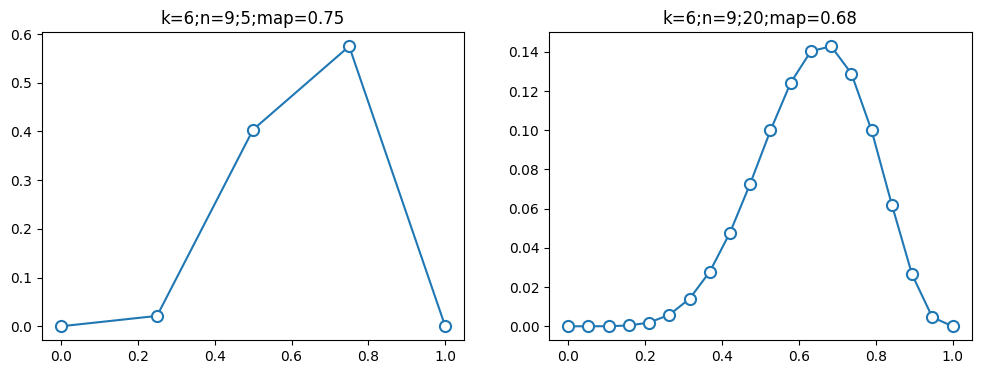

In [30]:
# grid approximation
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def grid_approx(k, n, resolution=20, ax=None, clip_prior=False):
    grid = np.linspace(0, 1, resolution)
    prior = np.ones(resolution)
    if clip_prior is not None:
        prior[grid < clip_prior] = 0
    lk = stats.binom.pmf(k, n, grid)
    unstd_post = lk * prior
    post = unstd_post / sum(unstd_post)
    mp = grid[post.argmax()]
    if ax is None:
        _, ax = plt.subplots()

    ax.plot(
        grid, post,
        '-o',
        markerfacecolor='white',
        markersize=8,
        markeredgewidth=1.5,
        zorder=3,
    )
    
    ax.set_title(f'{k=};{n=};{resolution};map={mp:.2f}')
    return mp


_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
grid_approx(6, 9, 5, ax=ax1)
grid_approx(6, 9, 20, ax=ax2)


ejercicio 2M1:

np.float64(0.7368421052631579)

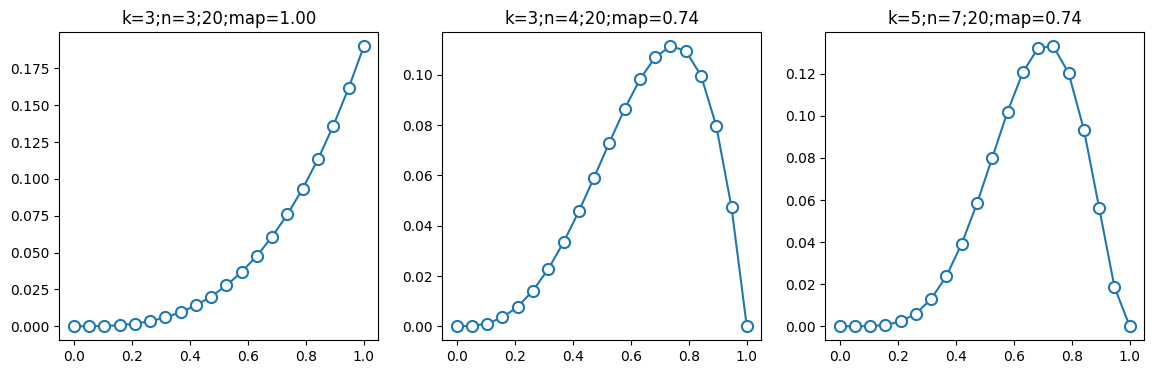

In [116]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[14, 4])
grid_approx(3, 3, ax=ax1)
grid_approx(3, 4, ax=ax2)
grid_approx(5, 7, ax=ax3)


ejercicio 2M2

np.float64(0.7368421052631579)

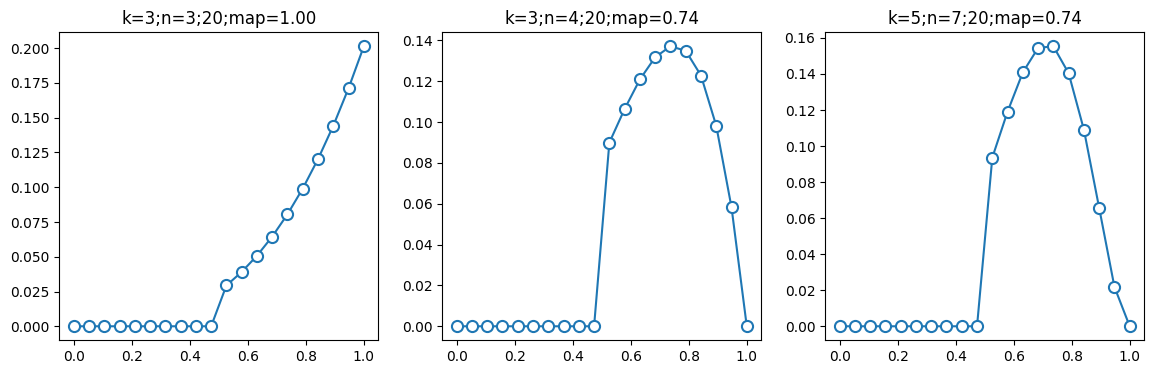

In [123]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[14, 4])
grid_approx(3, 3, ax=ax1, clip_prior=0.5)
grid_approx(3, 4, ax=ax2, clip_prior=0.5)
grid_approx(5, 7, ax=ax3, clip_prior=0.5)

Aproximación cuadrática.

In [ ]:
%%R
library(rethinking) # McElreath lib
globe.qa <- quap( # quadratic approximation
    alist(
        W ~ dbinom( W+L ,p) , # binomial likelihood
        p ~ dunif(0,1) # uniform prior
    ),
    data=list(W=6,L=3) 
)

# display summary of quadratic approximation
precis( globe.qa )

  mean   sd 5.5% 94.5%
p 0.67 0.16 0.42  0.92


Podemos utilizar PyMC para calcular la aproximación.
Esto funciona para la versión 5 de PyMC.

In [56]:
import pymc as pm
import scipy.stats as stats
W, L = 6, 3
N = W+L

with pm.Model() as globe_model: # definimos el modelo 
    p = pm.Uniform('p', 0, 1, default_transform=None)
    # Default transform None es vital o los estimadores serán
    # para el espacio no transformado y no corresponden con el libro
    lk = pm.Binomial('likelihood', observed=W, n=N, p=p)
    mp = pm.find_MAP(bounds=[(1e-9, 1-1e-9)])
    # Los límites son requeridos para que el estimador converja apropiadamente
    # debajo del capote utiliza scipy minimize.
    hess = pm.find_hessian(
        mp,
        negate_output=False
        # en la versión actual de pymc (5)
        # esto es necesario para evitar errores y advertencias, 
        # aunque la consecuencia es que el resultado es negativo.
    )

sd = (1/-hess[0,0])**0.5
# como el resultado es negativo, utilizamos el menos unario para 
# hacerlo positivo "-hess"
map_point = mp['p']
# Por fin la aproximación normal
lo, hi = stats.norm.ppf([0.055, 0.945], loc=map_point, scale=sd)

print('mean', 'std', '5.5%', '94.5%')
print('p', *np.array([map_point, sd, lo, hi]).round(2))

Output()

mean std 5.5% 94.5%
p 0.67 0.16 0.42 0.92


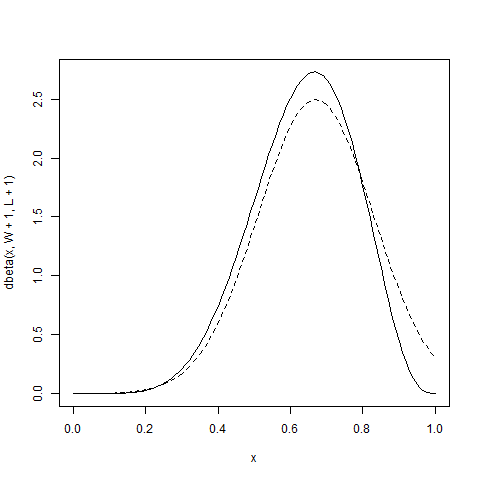

In [61]:
%%R
W <- 6
L <- 3
curve( dbeta( x , W+1 , L+1 ) , from=0 , to=1 )
# quadratic approximation
curve( dnorm( x , 0.67 , 0.16 ) , lty=2 , add=TRUE )

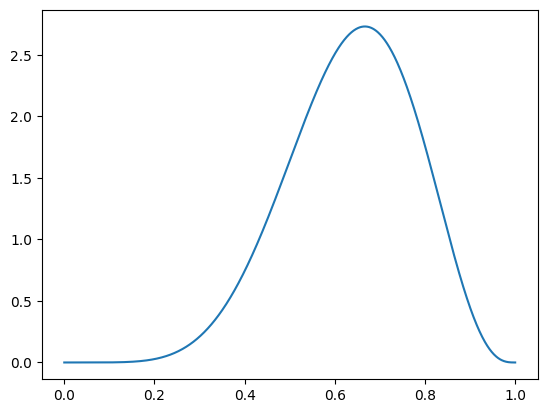

In [62]:
import scipy.stats as stats
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 1000)
y = stats.beta.pdf(x, W+1, L+1)
plt.plot(x, y)

This is the beta posterior from observed data updating from a uniform distribution.

Full MCMC model:

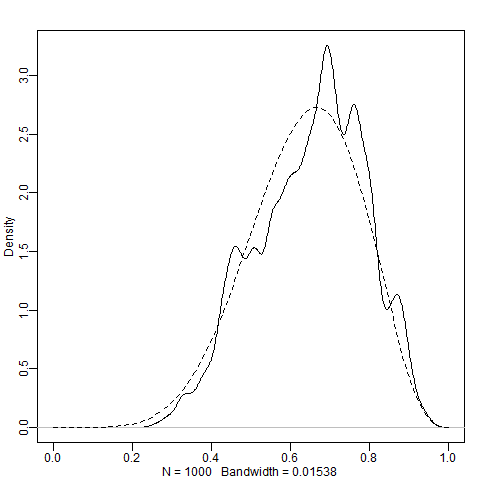

In [ ]:
%%R
n_samples <- 1000
p <- rep( NA , n_samples )
p[1] <- 0.5
W <- 6
L <- 3
for ( i in 2:n_samples ) {
p_new <- rnorm( 1 , p[i-1] , 0.1 )
    if ( p_new < 0 ) p_new <- abs( p_new )
    if ( p_new > 1 ) p_new <- 2 - p_new
    q0 <- dbinom( W , W+L , p[i-1] )
    q1 <- dbinom( W , W+L , p_new )
    p[i] <- ifelse( runif(1) < q1/q0 , p_new , p[i-1] )
}
dens( p , xlim=c(0,1) )
curve( dbeta( x , W+1 , L+1 ) , lty=2 , add=TRUE )

    mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
p  0.636  0.14   0.381    0.888      0.004    0.002    1227.0    1276.0    1.0


<Axes: title={'center': 'p'}>

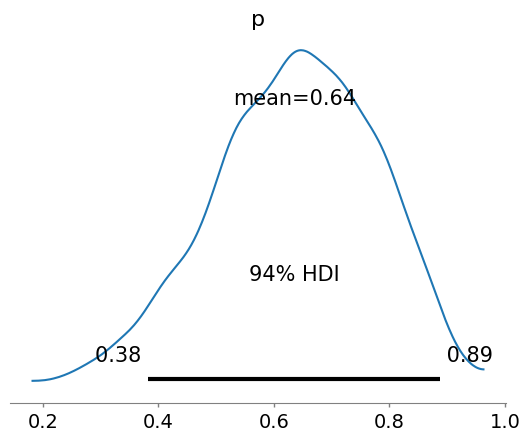

In [ ]:
import arviz as az
with pm.Model() as glob_model:
    p = pm.Beta('p', 1,1)
    lk = pm.Binomial('lk', p=p, n=W+L, observed=W)
    idata = pm.sample(nuts_sampler='blackjax', progressbar=None)
    # uso blackjax porque en windows el 
    # método por defacto genera errores de procesamiento en paralelo

print(az.summary(idata))
az.plot_posterior(idata)